###  Cart Pole - here, using the Classical Q-learning -trial2....... And trying out to adjust the hyperparameters

In [21]:
# import necessary modules
import gymnasium as gym
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

#### Creating the Cartpole environment

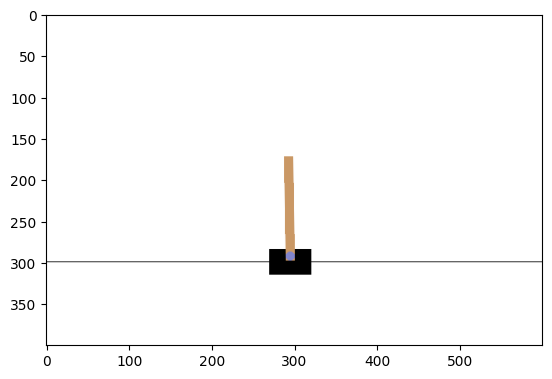

In [22]:
# Creating the game env
env = gym.make("CartPole-v1", render_mode='rgb_array')

# visualize the environment
env.reset()
plt.imshow(env.render())

In [23]:
# Here, setting the env boundaries
# to say -5 -> +5
env.observation_space

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

#### Above showed that the environment is a continuous space with shape (4,)- state here is a 4D vector. The range are lower bounds: [-4.8, -inf, -0.41887903, -inf] and upper bounds: [ 4.8, inf, 0.41887903, inf].
#### The values representation:
#### Cart Position (min: -4.8, max: 4.8)

#### Cart Velocity (unbounded)

#### Pole Angle (min: -0.418 rad ≈ -24°, max: 0.418 rad ≈ 24°)

#### Pole Angular Velocity (unbounded)

####  https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [24]:
# helper variables
# Need to adjust the amount of bins for better accuracy
# NB: the more bins the heavier agent to train (more memory needed also)
num_cart_position_bins = 40
num_cart_velocity_bins = 40
num_pole_angle_bins = 30
num_pole_angular_velocity_bins = 30

# for calculating the needed steps in the bins
max_cart_position = env.observation_space.high[0]
min_cart_position = env.observation_space.low[0]
max_cart_velocity = 5
min_cart_velocity = -5
max_pole_angle = env.observation_space.high[2]
min_pole_angle = env.observation_space.low[2]
max_pole_angular_velocity = 5
min_pole_angular_velocity = -5

# created the bins for position and velocity separately
# creating the ranges between the bins by using LINSPACE
cart_position_bins = np.linspace(min_cart_position, max_cart_position, num_cart_position_bins)
cart_velocity_bins = np.linspace(min_cart_velocity, max_cart_velocity, num_cart_velocity_bins)
pole_angle_bins = np.linspace(min_pole_angle, max_pole_angle, num_pole_angle_bins)
pole_angular_velocity_bins = np.linspace(min_pole_angular_velocity, max_pole_angular_velocity, num_pole_angular_velocity_bins)

# This calculate the number of states total in our Q-table
# with just 20-30 bins per observation variable
# the Q-table will be having 360000 states 
# then real size is doubled
num_states = num_cart_position_bins * num_cart_velocity_bins * num_pole_angle_bins * num_pole_angular_velocity_bins
print(f"Number of possible states based on the observation bins: {num_states}")

# finally, create an empty Q-table
Q_table = np.zeros((num_cart_position_bins, num_cart_velocity_bins, num_pole_angle_bins, num_pole_angular_velocity_bins, env.action_space.n))

Number of possible states based on the observation bins: 1440000


In [25]:
# double-check the shape that it matches the bins + actions
Q_table.shape

(40, 40, 30, 30, 2)

In [26]:
# this has to now match 4 observations.... quite impractical
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    # we need to accomodate both position and velocity
    # state[0] = cart position, state[1] = cart velocity, state[2] = pole angle, state[3] = pole angular velocity 
    Q[state[0], state[1], state[2], state[3], action] += alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], next_state[2], next_state[3]]) - Q[state[0], state[1], state[2], state[3], action])
    return Q

In [27]:
 # this also has to now match 4 observations
def get_state(observation):
    cart_position = np.digitize(observation[0], bins=cart_position_bins) - 1
    cart_velocity = np.digitize(observation[1], bins=cart_velocity_bins) - 1
    pole_angle = np.digitize(observation[2], bins=pole_angle_bins) - 1
    pole_angular_velocity = np.digitize(observation[3], bins=pole_angular_velocity_bins) - 1
    return cart_position, cart_velocity, pole_angle, pole_angular_velocity

### The Hyperparameters

In [28]:
# hyperparameters, see earlier Q-learning examples for explanations of each
# probably need to adjust these a bit after trying the training loop out
total_episodes = 50000
max_steps = 500
learning_rate = 0.5
gamma = 0.9
epsilon = 0.99
max_epsilon = 0.99
min_epsilon = 0.01
# decay_rate = 0.0003
decay_rate = 0.9995

# rule of thumb for the decay rate:
# use exponential decay if minimum epsilon is not part of an exit condition
# in the training loop
# if minimum epsilon is part of the exit condition => use linear decay (like in DQN)

#### The Q-Learning training loop

In [29]:
# training loop here
# for visualizing our reward progress while training
rewards = []

# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # get initial state
    state, info = env.reset()

    # every time you handle any kind of state (current, old, new)
    # you have to discretize it with your functions
    state = get_state(state)

    # from the beginning of the game, it shows the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, and total_rewards are 0
    total_rewards = 0

    # start playing the game in this episode
    for step in range(max_steps):

        # PHASE 1: exploration/exploitation
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            # fix this to use correct format
            action = np.argmax(Q_table[state[0], state[1], state[2], state[3]])
        else:
            # let's explore => random action
            action = env.action_space.sample()

        # Then the result is gotten from the action done
        # and unpack the results into: observation, reward, done
        new_state, reward, done, truncated, info = env.step(action)

        # convert the current observation into our bins
        new_state = get_state(new_state)

        # let's see if we have solved the environment => we have driven past the flag
        if done:
            reward = -100
        

        # update the Q-table with the values we have right now
        Q_table = calculate_value(Q_table, state, action, reward, new_state, learning_rate, gamma)

        # save current state and update rewards
        state = new_state
        total_rewards = total_rewards + reward

        # game over -> stop proceeding further
        if done:
            break

    # for visualization purposes, let's collect the rewards into a list
    rewards.append(total_rewards)        

    # applying the decay to epsilon
    # instead of linear decay, however have an expontential curve
    # epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    epsilon = max(min_epsilon, epsilon * decay_rate)

    print(f"Episode {episode} done, steps needed {step}, rewards: {total_rewards}, epsilon: {epsilon}")            

    # if epsilon is minimum and total rewards are almost maxed out => stop training
    # technically this is our "EarlyStop" -mechanism, you can use a more elaborate version if you need
    if epsilon == min_epsilon and total_rewards >= max_steps - 5:
        break

Episode 0 done, steps needed 11, rewards: -89.0, epsilon: 0.9895050000000001
Episode 1 done, steps needed 35, rewards: -65.0, epsilon: 0.9890102475000001
Episode 2 done, steps needed 13, rewards: -87.0, epsilon: 0.9885157423762502
Episode 3 done, steps needed 10, rewards: -90.0, epsilon: 0.9880214845050621
Episode 4 done, steps needed 11, rewards: -89.0, epsilon: 0.9875274737628096
Episode 5 done, steps needed 66, rewards: -34.0, epsilon: 0.9870337100259282
Episode 6 done, steps needed 17, rewards: -83.0, epsilon: 0.9865401931709153
Episode 7 done, steps needed 18, rewards: -82.0, epsilon: 0.98604692307433
Episode 8 done, steps needed 16, rewards: -84.0, epsilon: 0.9855538996127928
Episode 9 done, steps needed 13, rewards: -87.0, epsilon: 0.9850611226629865
Episode 10 done, steps needed 11, rewards: -89.0, epsilon: 0.984568592101655
Episode 11 done, steps needed 13, rewards: -87.0, epsilon: 0.9840763078056043
Episode 12 done, steps needed 43, rewards: -57.0, epsilon: 0.9835842696517015

#### I think, the agent initially performed poorly with low rewards and short episode durations, reflecting early exploration in training. As training progressed, the number of steps increased and rewards improved significantly, showing that the agent was learning the environment and optimizing its actions. The epsilon value decayed steadily from 0.99 to 0.01, reducing exploration and promoting exploitation. By episode 49,999, the agent consistently achieved longer steps and higher rewards, indicating successful training and effective policy development through Q-learning.

Rewards w/ running mean:

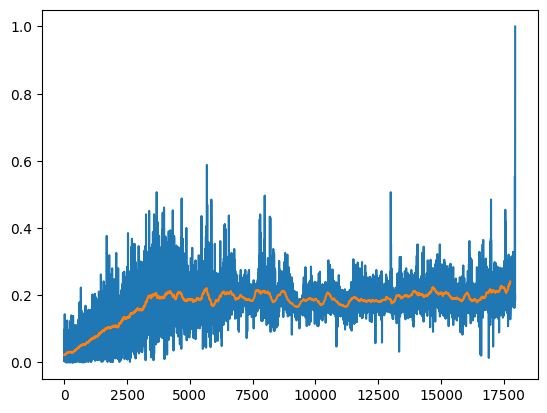

In [30]:
# convert the rewards -list into NumPy -array format
rewards_arr = np.array(rewards)

# define a window size for a moving average

# 50 is okay for 15000 episodes as the minimum window size
# NB: if the running mean line is too noisy, adjust the window size
# rule of thumb: many episodes => bigger window_ize
# 15000 => 30-50 is okay for window size
window_size = 200

# normalize the rewards (manual MinMax -normalization)
normalized_rewards = (rewards_arr - min(rewards_arr)) / (max(rewards_arr) - min(rewards_arr))

# calculate the running mean
running_mean = np.convolve(normalized_rewards, np.ones(window_size) / window_size, mode="valid")

print("Rewards w/ running mean:")
# visualize rewards + RUNNING MEAN
plt.plot(normalized_rewards)
plt.plot(running_mean)
plt.show()

#### It can be seen that the agent model started learning right from the beginning of the training process. Although it trained well but I think it can't be compared to the trial1 hyperparameters as there no too flunctuation. But it could be seen that on couple of times it goes up and down then up again.

#### Test the agent in the environment

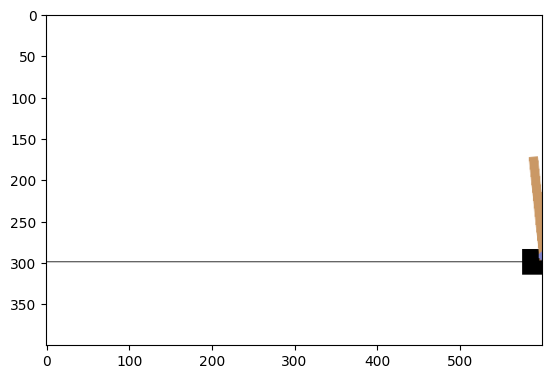

Total Reward: 170.0


In [31]:
# test the agent in the environment
# make a new environment for the test
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()
state = get_state(state)
total_reward = 0

# play the environment
for step in range(1000):
    # action = select_action(state, epsilon)
    action = np.argmax(Q_table[state[0], state[1], state[2], state[3]])
    state, reward, done, truncated, info = env.step(action)
    state = get_state(state)
    total_reward += reward

    # visualize frame
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    if done:
        break

# print result
print(f"Total Reward: {total_reward}")
env.close()
# we'll see if this plays well or not...

#### First attempt, it moved to the right (tilted) and then moved faster than the first trial (num_cart_position_bins = 30 , num_cart_velocity_bins = 30 , num_pole_angle_bins = 20 , num_pole_angular_velocity_bins = 20): And somehow balance when it got to say 180 as it was moving to the left and then tilted to the left and so not balance at the end of the testing at total reward 137

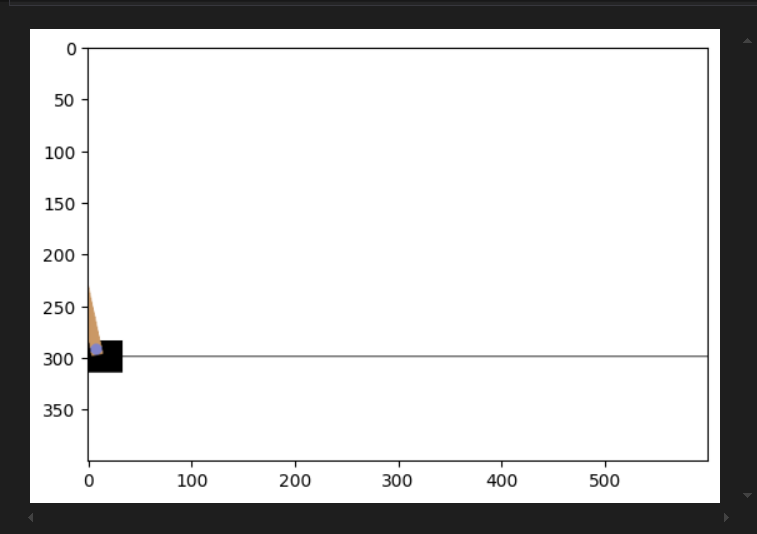

#### Second attempt, it started at 300 tilted slightly to the right which started to move faster to left and tried to balance at 175. However, continued to move to the left and almost balance say at 70 but didn't balance at the end of the testing at 154 total reward

### So I would say the smaller the helper parameters (num_cart_position_bins = 30 , num_cart_velocity_bins = 30 , num_pole_angle_bins = 20 , num_pole_angular_velocity_bins = 20) the better the trained Agent plays the game to balancing the Cartpole. I also think the plays significant role into balancing the Cartpole when the Agent playing the game, like it balanced well from the beginning of the playing. And started moving the left while it balanced almost at the end of the game then tilted to the right as seen below.

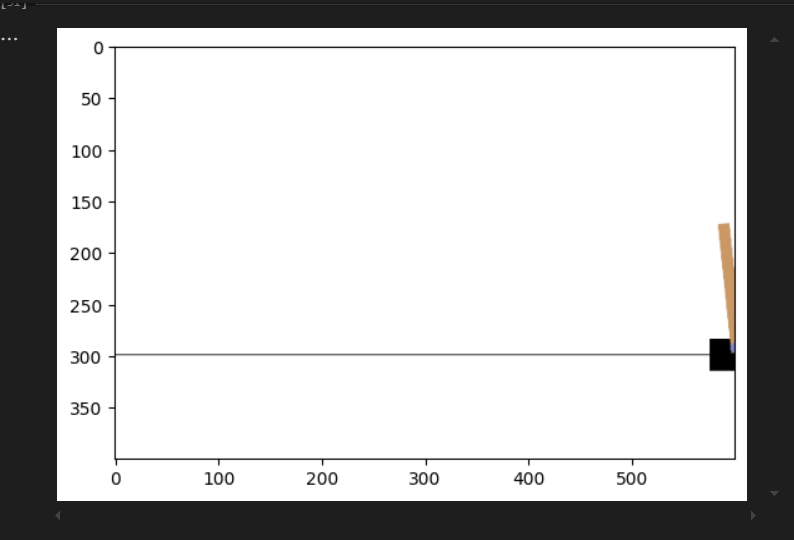